In [15]:
import cv2
import dlib
import numpy as np
import scipy as sp
from scipy.spatial import Delaunay
from matplotlib import pyplot as plt
from matplotlib.path import Path
from scipy.sparse import linalg, csr_matrix, lil_matrix

In [16]:
sam = cv2.cvtColor(cv2.imread('./my-images/sam.jpg'), cv2.COLOR_BGR2RGB)
ryan = cv2.cvtColor(cv2.imread('./my-images/ryan.jpg'), cv2.COLOR_BGR2RGB)

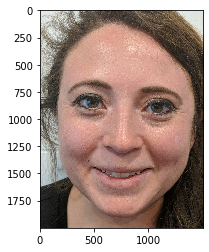

In [17]:
plt.figure()
plt.imshow(sam[950:2950, 650:2150, :])

In [18]:
sam_cropped = sam[950:2950, 650:2150, :].copy()

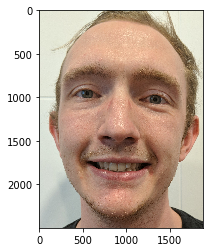

In [19]:
plt.figure()
plt.imshow(ryan[150:2650, 563:2438, :])

In [20]:
ryan_cropped = ryan[150:2650, 563:2438, :].copy()

In [21]:
# Keep aspect ratio of 4/3
sam_resized = cv2.resize(sam_cropped, (900, 1200))
ryan_resized = cv2.resize(ryan_cropped, (900, 1200))

In [22]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

In [23]:
sam_face = detector(sam_resized, 1)
ryan_face = detector(ryan_resized, 1)

In [24]:
sam_shape = predictor(sam_resized, sam_face[0])
ryan_shape = predictor(ryan_resized, ryan_face[0])

In [25]:
NUM_LANDMARKS = 68
sam_landmarks = np.zeros((NUM_LANDMARKS, 2))
ryan_landmarks = np.zeros((NUM_LANDMARKS, 2))
for idx in range(NUM_LANDMARKS):
    sam_landmarks[idx] = [sam_shape.part(idx).x, sam_shape.part(idx).y]
    ryan_landmarks[idx] = [ryan_shape.part(idx).x, ryan_shape.part(idx).y]

1-17 around edge of face starting at left eye, eight down the side, one at bottom of chin, eight up the other side to right eye
18-22 along top of left eyebrow from outside in
23-27 along top of right eyebrow from inside out
28-31 bridge of nose between eyes down to tip of nose
32-36 along bottom of nose from left to right
37-42 around left eye opening from left around the top to the right, then along the bottom
43-48 around right eye opening from left around the top to the right, then along the bottom
49-60 around outside of lips from left around the top to the right, then along the bottom
61-68 around inside of lips from left around the top to the right, then along the bottom

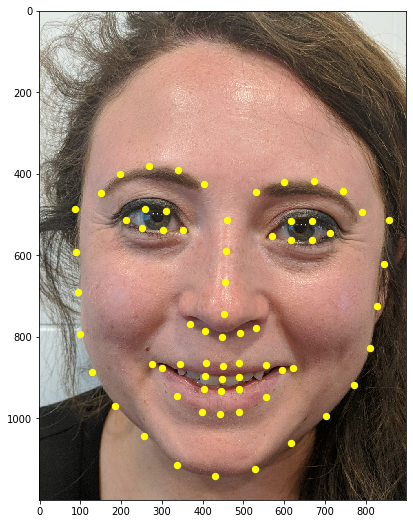

In [27]:
plt.figure(figsize=(12, 9))
plt.imshow(sam_resized)
plt.scatter(sam_landmarks[0:68, 0], sam_landmarks[0:68, 1], color="yellow", s=40)
plt.show()

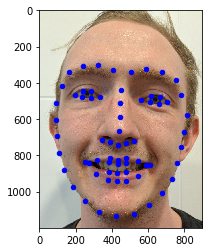

In [28]:
plt.figure()
plt.imshow(ryan_resized)
plt.scatter(ryan_landmarks[:, 0], ryan_landmarks[:, 1], color="blue", s=20)
plt.show()

In [29]:
sam_landmarks_plus_edge = np.zeros((90, 2))
ryan_landmarks_plus_edge = np.zeros((90, 2))

In [30]:
EDGE_LANDMARKS = [[0, 0],
                  [175, 0],
                  [350, 0],
                  [550, 0],
                  [725, 0],
                  [899, 0],
                  [0, 200],
                  [0, 400],
                  [0, 600],
                  [0, 800],
                  [0, 1000],
                  [0, 1199],
                  [175, 1199],
                  [350, 1199],
                  [550, 1199],
                  [725, 1199],
                  [899, 1199],
                  [899, 200],
                  [899, 400],
                  [899, 600],
                  [899, 800],
                  [899, 1000]]

In [31]:
sam_landmarks_plus_edge[0:68, :] = sam_landmarks.copy()
sam_landmarks_plus_edge[68:, :] = EDGE_LANDMARKS
ryan_landmarks_plus_edge[0:68, :] = ryan_landmarks.copy()
ryan_landmarks_plus_edge[68:, :] = EDGE_LANDMARKS

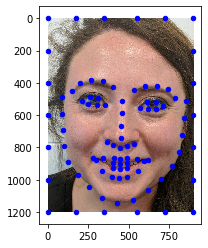

In [32]:
plt.figure()
plt.imshow(sam_resized)
plt.scatter(sam_landmarks_plus_edge[:, 0], sam_landmarks_plus_edge[:, 1], color="blue", s=20)
plt.show()

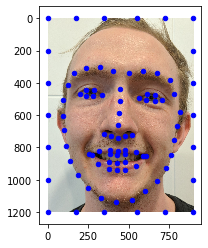

In [33]:
plt.figure()
plt.imshow(ryan_resized)
plt.scatter(ryan_landmarks_plus_edge[:, 0], ryan_landmarks_plus_edge[:, 1], color="blue", s=20)
plt.show()

In [34]:
sam_triangulation = Delaunay(sam_landmarks_plus_edge)
ryan_triangulation = Delaunay(ryan_landmarks_plus_edge)

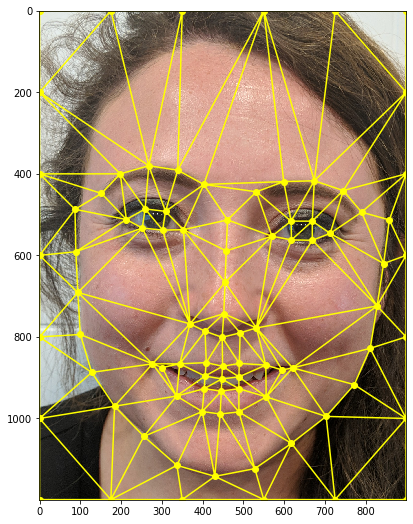

In [39]:
plt.figure(figsize=(12,9))
plt.imshow(sam_resized)
plt.triplot(sam_landmarks_plus_edge[:,0], sam_landmarks_plus_edge[:,1], sam_triangulation.simplices.copy(), color='yellow')
plt.plot(sam_landmarks_plus_edge[:,0], sam_landmarks_plus_edge[:,1], 'o', color='yellow')
plt.show()

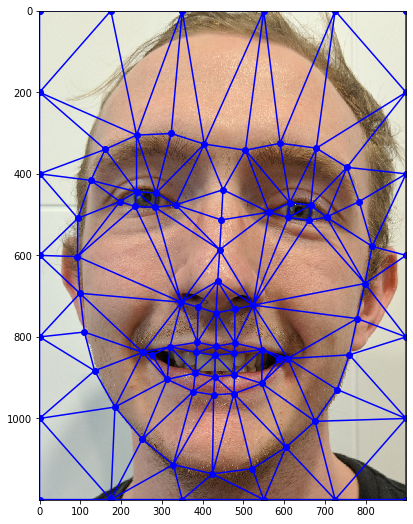

In [37]:
plt.figure(figsize=(12,9))
plt.imshow(ryan_resized)
plt.triplot(ryan_landmarks_plus_edge[:,0], ryan_landmarks_plus_edge[:,1], ryan_triangulation.simplices.copy(), color='blue')
plt.plot(ryan_landmarks_plus_edge[:,0], ryan_landmarks_plus_edge[:,1], 'o', color='blue')
plt.show()

In [163]:
def get_image_mask(W, H, vertices):
    mask = np.zeros((H, W, 3)).astype('uint8')
    mask = cv2.fillPoly(mask, [vertices], (1, 1, 1), lineType=4)
    return mask
    
#     x, y = np.meshgrid(np.arange(W), np.arange(H))
#     x, y = x.flatten(), y.flatten()

#     points = np.vstack((x,y)).T

#     path = Path(vertices)
#     mask = path.contains_points(points, radius=5.0)
#     mask = mask.reshape((H,W)).astype('uint8')
#     return mask

In [164]:
list(ryan_triangulation.simplices[0])

[71, 21, 70]

In [144]:
np_verts = np.take(ryan_landmarks_plus_edge, [71, 21, 70], axis=0).astype('int32')
ryan_verts = [tuple(point) for point in list(np.take(ryan_landmarks_plus_edge, [71, 21, 70], axis=0))]

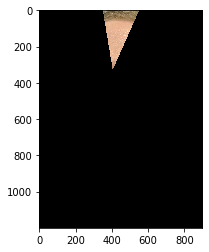

In [145]:
ryan_mask = get_image_mask(900, 1200, np_verts)
ryan_test = ryan_resized * ryan_mask[:, :, :]
plt.figure()
plt.imshow(ryan_test)

In [80]:
sam_verts = [tuple(point) for point in list(np.take(sam_landmarks_plus_edge, [71, 21, 70], axis=0))]

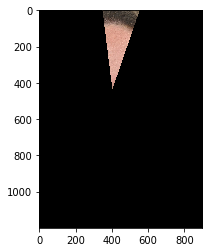

In [81]:
sam_mask = get_image_mask(900, 1200, sam_verts)
sam_test = sam_resized * sam_mask[:, :, None]
plt.figure()
plt.imshow(sam_test)

In [82]:
print(sam_verts)
print(ryan_verts)

[(550.0, 0.0), (403.0, 426.0), (350.0, 0.0)]
[(550.0, 0.0), (404.0, 327.0), (350.0, 0.0)]


In [83]:
A = lil_matrix((6,6))
b = np.zeros((6, 1))
equation = 0
for idx, vert in enumerate(ryan_verts):
    A[equation, :] = [vert[0], vert[1], 1, 0, 0, 0]
    A[equation+1, :] = [0, 0, 0, vert[0], vert[1], 1]
    b[equation] = sam_verts[idx][0]
    b[equation+1] = sam_verts[idx][1]
    equation += 2

In [84]:
A = A.tocsr()
results = linalg.lsqr(A, b, atol=1e-13, btol=1e-13)
v = results[0]
M = v.reshape((2,3))
inverse_M = cv2.invertAffineTransform(M)

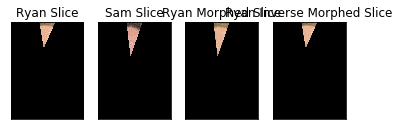

In [85]:
morphed = cv2.warpAffine(ryan_test, M, (900, 1200))
inverse_morphed = cv2.warpAffine(morphed, inverse_M, (900, 1200))

fig, axes = plt.subplots(1, 4)
axes[0].imshow(ryan_test, cmap='gray')
axes[0].set_title('Ryan Slice'), axes[0].set_xticks([]), axes[0].set_yticks([])
axes[1].imshow(sam_test, cmap='gray')
axes[1].set_title('Sam Slice'), axes[1].set_xticks([]), axes[1].set_yticks([])
axes[2].imshow(morphed, cmap='gray')
axes[2].set_title('Ryan Morphed Slice'), axes[2].set_xticks([]), axes[2].set_yticks([])
axes[3].imshow(inverse_morphed, cmap='gray')
axes[3].set_title('Ryan Inverse Morphed Slice'), axes[3].set_xticks([]), axes[3].set_yticks([]);

In [165]:
transformations = {}
ryan_masks = {}
for idx, triangle in enumerate(ryan_triangulation.simplices):
    ryan_verts = np.take(ryan_landmarks_plus_edge, triangle, axis=0).astype('int32')
    sam_verts = np.take(sam_landmarks_plus_edge, triangle, axis=0).astype('int32')
#     ryan_verts = [tuple(point) for point in list(np.take(ryan_landmarks_plus_edge, triangle, axis=0))]
#     sam_verts = [tuple(point) for point in list(np.take(sam_landmarks_plus_edge, triangle, axis=0))]
    
    A = lil_matrix((6,6))
    b = np.zeros((6, 1))
    equation = 0
    for idx2, vert in enumerate(ryan_verts):
        A[equation, :] = [vert[0], vert[1], 1, 0, 0, 0]
        A[equation+1, :] = [0, 0, 0, vert[0], vert[1], 1]
        b[equation] = sam_verts[idx2][0]
        b[equation+1] = sam_verts[idx2][1]
        equation += 2
    
    A = A.tocsr()
    results = linalg.lsqr(A, b, atol=1e-13, btol=1e-13)
    v = results[0]
    M = v.reshape((2,3))
    transformations[idx] = M
    
    ryan_mask = get_image_mask(900, 1200, ryan_verts)
    ryan_masks[idx] = ryan_mask
    

In [166]:
def blendImages(sourceTransform, referenceTransform):
    '''
    Naive blending for frame stitching
    Input:
        - sourceTransform: source frame projected onto reference frame plane
        - referenceTransform: reference frame projected onto same space
    Output:
        - blendedOutput: naive blending result from frame stitching
    '''

    blendedOutput = referenceTransform
    indices = referenceTransform == 0
    blendedOutput[indices] = sourceTransform[indices]

    return (blendedOutput / blendedOutput.max() * 255).astype(np.uint8)

In [193]:
morphed_face = np.zeros(ryan_resized.shape)
for idx in range(len(ryan_masks)):
    piece = ryan_resized * ryan_masks[idx][:, :, :]
    morphed_piece = cv2.warpAffine(piece, transformations[idx], (900, 1200))
    morphed_face = blendImages(morphed_piece, morphed_face)

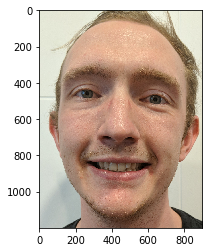

In [194]:
plt.figure()
plt.imshow(ryan_resized)

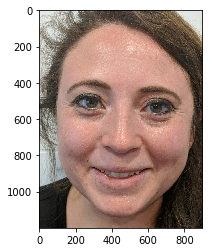

In [195]:
plt.figure()
plt.imshow(sam_resized)

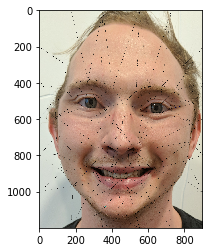

In [196]:
plt.figure()
plt.imshow(morphed_face)

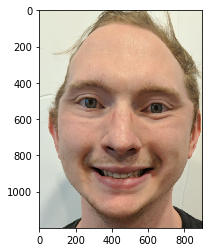

In [202]:
final = cv2.medianBlur(morphed_face, 5)
plt.figure()
plt.imshow(final)

#### Practicing

In [2]:
sam2 = cv2.imread('./my-images/sam2.jpg')

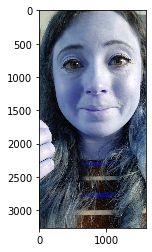

In [3]:
plt.figure()
plt.imshow(sam2)

In [4]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

In [5]:
rects = detector(sam2, 1)

In [6]:
len(rects)

1

In [7]:
shape = predictor(sam2, rects[0])

In [8]:
NUM_LANDMARKS = 68
face_landmarks = np.zeros((NUM_LANDMARKS, 2))
for idx in range(NUM_LANDMARKS):
    face_landmarks[idx] = [shape.part(idx).x, shape.part(idx).y]

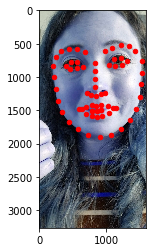

In [10]:
plt.figure()
plt.imshow(sam2)
plt.scatter(face_landmarks[:, 0], face_landmarks[:, 1], color="red", s=20)
plt.show()

In [13]:
triangulation = Delaunay(face_landmarks)

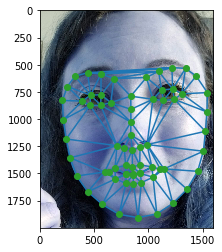

In [22]:
plt.figure()
plt.imshow(sam2[0:2000, :, :])
plt.triplot(face_landmarks[:,0], face_landmarks[:,1], triangulation.simplices.copy())
plt.plot(face_landmarks[:,0], face_landmarks[:,1], 'o')
plt.show()

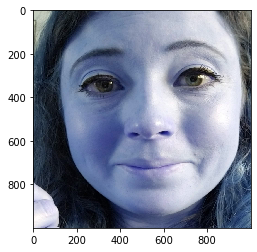

In [40]:
test = sam2.copy()
test = test[200:2000, :, :]
test = cv2.resize(test, (1000, 1000))
plt.figure()
plt.imshow(test)

In [41]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

In [42]:
rects = detector(test, 1)

In [43]:
len(rects)

1

In [44]:
shape = predictor(test, rects[0])

In [45]:
NUM_LANDMARKS = 68
face_landmarks = np.zeros((NUM_LANDMARKS, 2))
for idx in range(NUM_LANDMARKS):
    face_landmarks[idx] = [shape.part(idx).x, shape.part(idx).y]

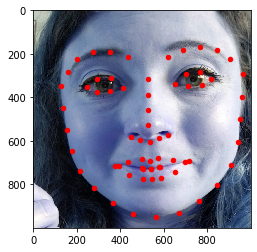

In [46]:
plt.figure()
plt.imshow(test)
plt.scatter(face_landmarks[:, 0], face_landmarks[:, 1], color="red", s=20)
plt.show()

In [47]:
face_landmarks.shape

(68, 2)

In [52]:
test_landmarks = np.zeros((88, 2))

In [53]:
edge_landmarks = [[0, 0],
                  [0, 200],
                  [0, 400],
                  [0, 600],
                  [0, 800],
                  [0, 999],
                  [200, 0],
                  [400, 0],
                  [600, 0],
                  [800, 0],
                  [999, 0],
                  [999, 200],
                  [999, 400],
                  [999, 600],
                  [999, 800],
                  [999, 999],
                  [200, 999],
                  [400, 999],
                  [600, 999],
                  [800, 999]]

In [54]:
test_landmarks[0:68, :] = face_landmarks.copy()
test_landmarks[68:, :] = edge_landmarks

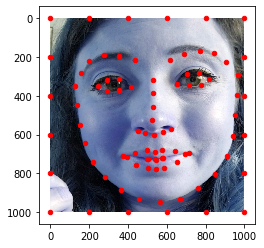

In [55]:
plt.figure()
plt.imshow(test)
plt.scatter(test_landmarks[:, 0], test_landmarks[:, 1], color="red", s=20)
plt.show()

In [56]:
triangulation = Delaunay(test_landmarks)

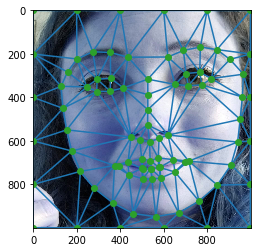

In [57]:
plt.figure()
plt.imshow(test)
plt.triplot(test_landmarks[:,0], test_landmarks[:,1], triangulation.simplices.copy())
plt.plot(test_landmarks[:,0], test_landmarks[:,1], 'o')
plt.show()